---
**Fire Detection Model**
---

---
**Data Preprocessing**
---
Link to first [dataset](https://www.kaggle.com/datasets/tharakan684/urecamain)

Data Preprocessing performed starts by mounting google drive to load the dataset by setting the path to the root directory of the dataset.


In [1]:
import cv2
import os
import torchvision


In [2]:
# Mount Google drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


---
**DATA PREPROCEESSING**
---

In [3]:


# Set path to the dataset
train = '/content/drive/MyDrive/fire_detection/Train'
test = '/content/drive/MyDrive/fire_detection/Test'
valid =  '/content/drive/MyDrive/fire_detection/Valid'

# Define the class labels
class_labels = ['Fire', 'Non-Fire']

# Define the target size for resizing
target_size = (280, 280)

# Define the number of augmented images to generate per original image
augmentation_factor = 5

# Create a transform object for data augmentation and normalization
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.RandomResizedCrop(target_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an instance of the ImageFolder class to load the images and labels from the train folder
x_train = torchvision.datasets.ImageFolder(train, transform=transform)
x_test = torchvision.datasets.ImageFolder(test, transform=transform)
x_valid = torchvision.datasets.ImageFolder(valid, transform=transform)


---
**DATA VISUALIZATION**
---

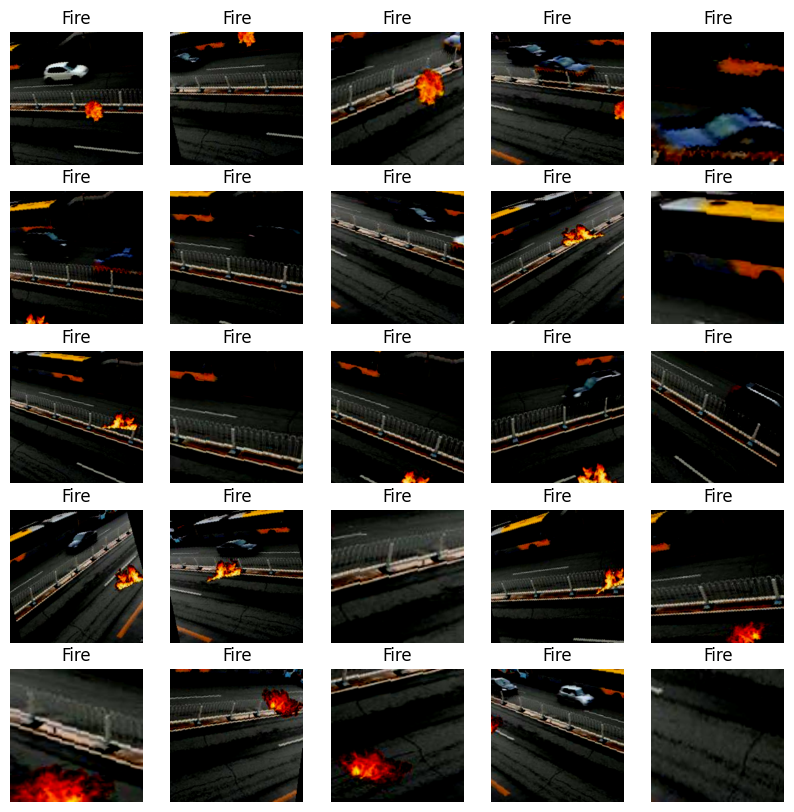

In [4]:
# Import the matplotlib module
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
# Loop through the first 10 images in the train dataset
for i in range(25):
  # Get the image and label at index i
  image, label = x_train[i]

  # Convert the image from tensor to numpy array
  image = image.numpy()

  # Convert the image from CHW to HWC format
  image = np.transpose(image, (1, 2, 0))

  # Display the image using plt.imshow
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(class_labels[label])
  plt.axis('off')
plt.show()


---
# **PRETEXT TASK**
---
To implement the pretext task or a self supervised learning task that can effectively capture the visual features related to fire scenes by leveraging the preprocessed, unlabeled data to guide the learning process.



---
**COLORIZATION**
---


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
from PIL import Image
import os
import time

# Function to convert RGB to grayscale and return as a tensor
def rgb_to_gray_tensor(rgb_tensor):
    gray_tensor = 0.2989 * rgb_tensor[0] + 0.5870 * rgb_tensor[1] + 0.1140 * rgb_tensor[2]
    return gray_tensor.unsqueeze(0)

# Custom dataset for colorization pretext task
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = self._make_dataset()

    def _make_dataset(self):
        images = []
        for root, _, fnames in sorted(os.walk(self.root)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                images.append(path)
        return images

    def __getitem__(self, index):
        path = self.samples[index]
        image = Image.open(path).convert('RGB')
        if self.transform is not None:
            gray_image, rgb_image = self.transform(image)
            return gray_image, rgb_image

    def __len__(self):
        return len(self.samples)

# Custom transform for colorization pretext task
class ColorizationTransform:
    def __call__(self, rgb_image):
        gray_image = rgb_to_gray_tensor(transforms.ToTensor()(rgb_image))
        rgb_tensor = transforms.ToTensor()(rgb_image)
        return gray_image, rgb_tensor

# Set path to the dataset
train = '/content/drive/MyDrive/fire_detection/Train'

# Apply colorization transform to the dataset
colorization_transform = ColorizationTransform()
x_train_colorization = ColorizationDataset(train, transform=colorization_transform)

# Create data loader
batch_size = 32
train_loader_colorization = DataLoader(x_train_colorization, batch_size=batch_size, shuffle=True)

# Iterate through the data loader to see if it runs
start_time = time.time()

for gray_images, rgb_images in train_loader_colorization:
    print(gray_images.size(), rgb_images.size())
    break

end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))


torch.Size([32, 1, 224, 224]) torch.Size([32, 3, 224, 224])
Execution time: 78.87 seconds


**ROTATION PREDICTION**

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
from PIL import Image
import os
import random

# Function to perform random rotation on the image and return the rotation angle label
def random_rotation(image):
    angle = random.choice([0, 90, 180, 270])
    rotated_image = image.rotate(angle)
    return rotated_image, angle

# Custom dataset for rotation prediction pretext task
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = self._make_dataset()

    def _make_dataset(self):
        images = []
        for root, _, fnames in sorted(os.walk(self.root)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                images.append(path)
        return images

    def __getitem__(self, index):
        path = self.samples[index]
        image = Image.open(path).convert('RGB')
        if self.transform is not None:
            rotated_image, angle = self.transform(image)
            return rotated_image, angle

    def __len__(self):
        return len(self.samples)

# Custom transform for rotation prediction pretext task
class RotationTransform:
    def __call__(self, rgb_image):
        rotated_image, angle = random_rotation(rgb_image)
        rgb_tensor = transforms.ToTensor()(rotated_image)
        return rgb_tensor, angle

# Set path to the dataset
train = '/content/drive/MyDrive/fire_detection/Train'

# Apply rotation transform to the dataset
rotation_transform = RotationTransform()
x_train_rotation = RotationDataset(train, transform=rotation_transform)

# Create data loader
batch_size = 32
train_loader_rotation = DataLoader(x_train_rotation, batch_size=batch_size, shuffle=True)

# Iterate through the data loader to see if it runs
for rotated_images, rotation_angles in train_loader_rotation:
    print(rotated_images.size(), rotation_angles)
    break


torch.Size([32, 3, 224, 224]) tensor([  0,   0, 270, 180,  90, 270, 270, 180,  90,  90,   0,  90, 270, 270,
        180, 180, 270, 180,   0, 270,   0,  90, 270,   0, 180, 180,  90, 180,
        180,  90,  90, 180])


# Feature Representation ⚫

## Colorization Model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
import os
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Define the architecture for the colorization model
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Use sigmoid activation to ensure outputs are in [0, 1] range
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # Resize the output to match the size of RGB images (224x224)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x

# Instantiate the colorization model
colorization_model = ColorizationModel()


In [ ]:

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(colorization_model.parameters(), lr=0.001)

# Training loop for colorization pretext task
num_epochs = 10

if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device('cuda')
else:
    print("GPU is not available. Using CPU.")
    device = torch.device('cpu')

colorization_model.to(device)

for epoch in range(num_epochs):
    total_loss = 0.0
    for gray_images, rgb_images in train_loader_colorization:

        gray_images = gray_images.to(device)
        rgb_images = rgb_images.to(device)
        # Forward pass
        outputs = colorization_model(gray_images)

        # Compute loss
        loss = criterion(outputs, rgb_images)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader_colorization)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

# Save the trained colorization model
torch.save(colorization_model.state_dict(), 'colorization_model.pth')

GPU is not available. Using CPU.
Epoch 1/10, Loss: 0.01643756045860813
Epoch 2/10, Loss: 0.01153171907099796
